In [1]:
import requests
import geopandas as gpd
import pandas as pd
import os
# import requests_cache
# from requests.adapters import HTTPAdapter
# from requests.packages.urllib3.util.retry import Retry
# import openmeteo_requests
# OPENMETEO_AVAILABLE = True
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

import matplotlib.pyplot as plt
# import geoviews.feature as gf
# import xarray as xr
# from cartopy import crs
# from geoviews import opts
# import geoviews as gv
# gv.extension('bokeh', 'matplotlib')
import geopandas as gpd
import seaborn as sns

# for basemaps
# import contextily as ctx

# For spatial statistics
# import esda
# from esda.moran import Moran, Moran_Local

# import splot
# from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

# import libpysal as lps

# Graphics
# import plotly.express as px


In [64]:
def temp_humi_rain_data(latitude, longitude):
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)

    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": "2010-01-01",
        "end_date": "2024-09-01",
        "daily": ["temperature_2m_mean", "apparent_temperature_mean", "precipitation_sum", "rain_sum"]
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

    # Process daily data. The order of variables needs to be the same as requested.
    daily = response.Daily()
    daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()
    daily_apparent_temperature_mean = daily.Variables(1).ValuesAsNumpy()
    daily_precipitation_sum = daily.Variables(2).ValuesAsNumpy()
    daily_rain_sum = daily.Variables(3).ValuesAsNumpy()

    daily_data = {"date": pd.date_range(
        start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
        end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = daily.Interval()),
        inclusive = "left"
    )}
    daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
    daily_data["apparent_temperature_mean"] = daily_apparent_temperature_mean
    daily_data["precipitation_sum"] = daily_precipitation_sum
    daily_data["rain_sum"] = daily_rain_sum
    daily_data["latitude"] = latitude
    daily_data["longitude"] = longitude
    daily_dataframe = pd.DataFrame(data = daily_data)

    return daily_dataframe


In [65]:
def flood_data(latitude, longitude):
    cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)

    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://flood-api.open-meteo.com/v1/flood"
    params = {
        "latitude": 59.91,
        "longitude": 10.75,
        "daily": ["river_discharge", "river_discharge_mean", "river_discharge_median", "river_discharge_max", "river_discharge_min"],
        "start_date": "2010-01-01",
        "end_date": "2024-09-01"
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

    # Process daily data. The order of variables needs to be the same as requested.
    daily = response.Daily()
    daily_river_discharge = daily.Variables(0).ValuesAsNumpy()
    daily_river_discharge_mean = daily.Variables(1).ValuesAsNumpy()
    daily_river_discharge_median = daily.Variables(2).ValuesAsNumpy()
    daily_river_discharge_max = daily.Variables(3).ValuesAsNumpy()
    daily_river_discharge_min = daily.Variables(4).ValuesAsNumpy()

    daily_data = {"date": pd.date_range(
        start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
        end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = daily.Interval()),
        inclusive = "left"
    )}

    daily_data["river_discharge"] = daily_river_discharge
    daily_data["river_discharge_mean"] = daily_river_discharge_mean
    daily_data["river_discharge_median"] = daily_river_discharge_median
    daily_data["river_discharge_max"] = daily_river_discharge_max
    daily_data["river_discharge_min"] = daily_river_discharge_min

    daily_dataframe = pd.DataFrame(data = daily_data)
    return daily_dataframe

In [11]:
# # https://geocoding-api.open-meteo.com/v1/search?name=Niamey&count=50&language=en&format=json

# url = "https://climate-api.open-meteo.com/v1/climate"
# params = {
#     "latitude": 13.5137,
#     "longitude": 2.1098,
#     "start_date": "2000-01-01",
#     "end_date": "2024-01-01",
#     "daily": ["shortwave_radiation_sum", "pressure_msl_mean", "soil_moisture_0_to_10cm_mean", "et0_fao_evapotranspiration_sum"]
# }
# responses = openmeteo.weather_api(url, params=params)

In [12]:
url = "https://geocoding-api.open-meteo.com/v1/search?name=Niamey&count=10&language=en&format=json"

params = {
    "latitude": 13.5137,
    "longitude": 2.1098,
}


In [66]:
def climate_data(latitude, longitude):
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)

    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://climate-api.open-meteo.com/v1/climate"
    params = {
        "latitude": 13.5137,
        "longitude": 2.1098,
        "start_date": "2010-01-01",
        "end_date": "2024-09-01",
        "daily": ["shortwave_radiation_sum", "pressure_msl_mean", "soil_moisture_0_to_10cm_mean", "et0_fao_evapotranspiration_sum"]
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

    # Process daily data. The order of variables needs to be the same as requested.
    daily = response.Daily()
    daily_shortwave_radiation_sum = daily.Variables(0).ValuesAsNumpy()
    daily_pressure_msl_mean = daily.Variables(1).ValuesAsNumpy()
    daily_soil_moisture_0_to_10cm_mean = daily.Variables(2).ValuesAsNumpy()
    daily_et0_fao_evapotranspiration_sum = daily.Variables(3).ValuesAsNumpy()

    daily_data = {"date": pd.date_range(
        start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
        end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = daily.Interval()),
        inclusive = "left"
    )}
    daily_data["shortwave_radiation_sum"] = daily_shortwave_radiation_sum
    daily_data["pressure_msl_mean"] = daily_pressure_msl_mean
    daily_data["soil_moisture_0_to_10cm_mean"] = daily_soil_moisture_0_to_10cm_mean
    daily_data["et0_fao_evapotranspiration_sum"] = daily_et0_fao_evapotranspiration_sum

    daily_dataframe = pd.DataFrame(data = daily_data)
    return daily_dataframe

In [5]:

def get_coordinates(location):
    geolocator = Nominatim(user_agent="my_agent")
    try:
        # Attempt to geocode the location
        location_data = geolocator.geocode(location, timeout=10)
        
        if location_data:
            latitude = location_data.latitude
            longitude = location_data.longitude
            return latitude, longitude
        else:
            return None, None
    except (GeocoderTimedOut, GeocoderUnavailable):
        print("Error: Geocoding service timed out or unavailable. Please try again later.")
        return None, None

# Example usage
location = "Niamey, Niger"
lat, lon = get_coordinates(location)

if lat and lon:
    print(f"Coordinates for {location}:")
    print(f"Latitude: {lat}")
    print(f"Longitude: {lon}")
else:
    print(f"Could not find coordinates for {location}")



Coordinates for Niamey, Niger:
Latitude: 13.524834
Longitude: 2.109823


In [6]:
test = climate_data(lat, lon)
test

Coordinates 13.5°N 2.100006103515625°E
Elevation 202.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


,date,shortwave_radiation_sum,pressure_msl_mean,soil_moisture_0_to_10cm_mean,et0_fao_evapotranspiration_sum
0,2000-01-01 00:00:00+00:00,21.150856,1014.973083,0.030735,6.558338
1,2000-01-02 00:00:00+00:00,21.252209,1014.673035,0.030681,6.688530
2,2000-01-03 00:00:00+00:00,21.362318,1013.884033,0.030518,6.704773
3,2000-01-04 00:00:00+00:00,21.570112,1013.295044,0.030354,6.678779
4,2000-01-05 00:00:00+00:00,21.875753,1013.705994,0.030191,6.582730
...,...,...,...,...,...
8762,2023-12-28 00:00:00+00:00,20.194490,1011.717957,0.030513,6.609223
8763,2023-12-29 00:00:00+00:00,20.482523,1011.606750,0.030569,6.756763
8764,2023-12-30 00:00:00+00:00,20.867933,1011.095581,0.030624,6.933623
8765,2023-12-31 00:00:00+00:00,20.765699,1011.084351,0.030680,6.865988


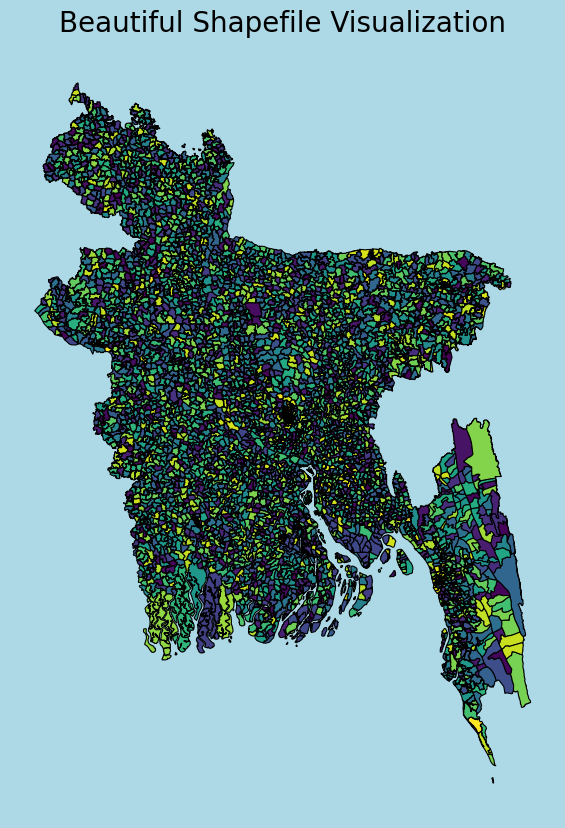

In [6]:
directory = "C:/Users/bachi/Documents/GIT_PROJECTS/Assessing-Urban-Flood-Risk-in-Dhaka-Bangladesh/data/Raw/bangladesh-latest-free.shp/"
# Path to your shapefile
shapefile_path = "C:/Users/bachi/Documents/GIT_PROJECTS/Assessing-Urban-Flood-Risk-in-Dhaka-Bangladesh/data/Raw/bgd_adm_bbs_20201113_SHP/bgd_admbnda_adm4_bbs_20201113.shp"

# Load the shapefile into a GeoDataFrame
gdf = gpd.read_file(shapefile_path)

# Print the first few rows of the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plotting with additional style options
gdf.plot(
    ax=ax,
    edgecolor='black',          # Set boundary line color
    linewidth=0.8,              # Adjust the thickness of the boundaries
    cmap='viridis',             # Color map for polygons
    legend=True                 # Display a color legend if applicable
)

# Customizing the plot title and axis appearance
ax.set_title("Beautiful Shapefile Visualization", fontdict={'fontsize': 20}, pad=12)
ax.set_axis_off()  # Turns off the axis

# Add gridlines for aesthetic effect
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

# Add a background color for the figure
fig.patch.set_facecolor('lightblue')

# Show the plot
plt.show()
# List to store GeoDataFrames
# gdfs = []

# # Loop through all the files in the directory
# for filename in os.listdir(directory):
#     if filename.endswith(".shp"):
#         shapefile_path = os.path.join(directory, filename)
#         gdf = gpd.read_file(shapefile_path)
#         gdfs.append(gdf)

# # Combine all GeoDataFrames into one (optional, if you want to plot all together)
# combined_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

# # Plot all the shapefiles together
# combined_gdf.plot()
# plt.title("Combined Shapefiles of Dhaka")
# plt.show()

In [7]:
gdf_dhaka = gdf[gdf["ADM1_EN"] == "Dhaka"]

In [8]:
# gdf[gdf["ADM1_EN"] == "Dhaka"]

##Get centroid coordinate based on the geometry data
def centroid_latitude(geometry):
    return(geometry.centroid.coords[0][1])

def centroid_longitude(geometry):
    return(geometry.centroid.coords[0][0])



gdf_dhaka["latitude"] = gdf_dhaka["geometry"].apply(centroid_latitude)
gdf_dhaka["longitude"] = gdf_dhaka["geometry"].apply(centroid_longitude)    


c:\Users\bachi\Documents\GIT_PROJECTS\GIS_Project\venv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\bachi\Documents\GIT_PROJECTS\GIS_Project\venv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [52]:
import pandas as pd
from tqdm import tqdm
import concurrent.futures

def process_location(row):
    latitude = row['latitude']
    longitude = row['longitude']

    # Call the flood_data function to get flood-related data (daily)
    flood_df = flood_data(latitude, longitude)

    # Resample flood data to monthly
    flood_monthly = flood_df.resample('ME', on='date').mean()

    # Call the temp_humi_rain_data function (already monthly)
    climate_df = temp_humi_rain_data(latitude, longitude)

    # Ensure the date is at the end of the month for climate_df
    climate_df['date'] = climate_df['date'] + pd.offsets.MonthEnd(0)

    # Merge the flood and climate DataFrames based on the 'date' column
    monthly_df = pd.merge(flood_monthly, climate_df, left_index=True, right_on='date')

    # Reset the index if needed
    monthly_df = monthly_df.reset_index(drop=True)

    # Add year and month columns
    monthly_df['year'] = monthly_df['date'].dt.year
    monthly_df['month'] = monthly_df['date'].dt.month
    
    # Create a new date column for the last day of each month
    monthly_df['date_my'] = pd.to_datetime(monthly_df['year'].astype(str) + '-' + 
                                        monthly_df['month'].astype(str) + '-01') 


    # Add all columns from the original coordinate_df row
    for col in row.index:
        monthly_df[col] = row[col]

    return monthly_df

def aggregate_climate_data(coordinate_df):
    total_locations = len(coordinate_df)
    processed_locations = 0
    results = []

    pbar = tqdm(total=total_locations, desc="Processing locations")

    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        future_to_row = {executor.submit(process_location, row): row for _, row in coordinate_df.iterrows()}

        for future in concurrent.futures.as_completed(future_to_row):
            try:
                result = future.result()
                results.append(result)
                processed_locations += 1
                pbar.update(1)
                pbar.set_postfix({"Processed": f"{processed_locations}/{total_locations}"})
            except Exception as exc:
                print(f'Location processing generated an exception: {exc}')
                print(f'Error occurred for row: {future_to_row[future]}')

    pbar.close()

    if not results:
        print("No data was processed successfully.")
        return None

    combined_df = pd.concat(results, ignore_index=True)
    print(f"\r\nTotal rows in final DataFrame: {len(combined_df)}")
    print(f"Date range: {combined_df['date'].min()} to {combined_df['date'].max()}")
    print(f"Number of unique locations: {combined_df['latitude'].nunique()}")
    return combined_df

In [67]:
result_df = aggregate_climate_data(gdf_dhaka.head(5))

output_shapefile_path = "C:/Users/bachi/Documents/GIT_PROJECTS/Assessing-Urban-Flood-Risk-in-Dhaka-Bangladesh/data/Raw/bgd_adm_bbs_20201113_SHP/Dhaka_with_api_data.shp"

# Save the GeoDataFrame as a shapefile
gdf.to_file(output_shapefile_path)

Processing locations:   0%|          | 0/5 [00:00<?, ?it/s]

Coordinates 59.900001525878906°N 10.75°E
Elevation nan m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 59.900001525878906°N 10.75°E
Elevation nan m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 59.900001525878906°N 10.75°E
Elevation nan m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 59.900001525878906°N 10.75°E
Elevation nan m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 59.900001525878906°N 10.75°E
Elevation nan m asl
Timezone None None
Timezone difference to GMT+0 0 s


C:\Users\bachi\AppData\Local\Temp\ipykernel_13016\1312786218.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  flood_monthly = flood_df.resample('M', on='date').mean()
C:\Users\bachi\AppData\Local\Temp\ipykernel_13016\1312786218.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  flood_monthly = flood_df.resample('M', on='date').mean()
C:\Users\bachi\AppData\Local\Temp\ipykernel_13016\1312786218.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  flood_monthly = flood_df.resample('M', on='date').mean()
C:\Users\bachi\AppData\Local\Temp\ipykernel_13016\1312786218.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  flood_monthly = flood_df.resample('M', on='date').mean()
C:\Users\bachi\AppData\Local\Temp\ipykernel_13016\1312786218.py:13: FutureWarning: 'M' is deprec

In [61]:
result_df["date_my"].unique()

<DatetimeArray>
['2000-01-01 00:00:00', '2000-02-01 00:00:00', '2000-03-01 00:00:00',
 '2000-04-01 00:00:00', '2000-05-01 00:00:00', '2000-06-01 00:00:00',
 '2000-07-01 00:00:00', '2000-08-01 00:00:00', '2000-09-01 00:00:00',
 '2000-10-01 00:00:00',
 ...
 '2023-04-01 00:00:00', '2023-05-01 00:00:00', '2023-06-01 00:00:00',
 '2023-07-01 00:00:00', '2023-08-01 00:00:00', '2023-09-01 00:00:00',
 '2023-10-01 00:00:00', '2023-11-01 00:00:00', '2023-12-01 00:00:00',
 '2024-01-01 00:00:00']
Length: 289, dtype: datetime64[ns]

In [56]:
print(result_df[['date', 'year', 'month']].tail(10))

            date  year  month
43825 2015-01-01  2023     12
43826 2015-01-01  2023     12
43827 2015-01-01  2023     12
43828 2015-01-01  2023     12
43829 2015-01-01  2023     12
43830 2015-01-01  2023     12
43831 2015-01-01  2023     12
43832 2015-01-01  2023     12
43833 2015-01-01  2023     12
43834 2015-01-01  2024      1


In [ ]:
temp_humi_rain_data(latitude, longitude):
climate_data(latitude, longitude):
flood_data(latitude, longitude)

In [25]:
get_coordinates("Tongibari, Bangladesh")

(23.5102866, 90.4659685)

In [20]:
test = temp_humi_rain_data(23.5102866, 90.4659685)

Coordinates 23.514936447143555°N 90.47368621826172°E
Elevation 9.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


In [22]:
test.resample('M', on='date').mean().reset_index()

C:\Users\bachi\AppData\Local\Temp\ipykernel_13016\749263979.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test.resample('M', on='date').mean().reset_index()


,date,temperature_2m_mean,apparent_temperature_mean,precipitation_sum,rain_sum,latitude,longitude
0,2000-01-31 00:00:00+00:00,19.102598,19.417524,0.251613,0.251613,23.510287,90.465969
1,2000-02-29 00:00:00+00:00,20.451014,20.873554,0.562069,0.562069,23.510287,90.465969
2,2000-03-31 00:00:00+00:00,25.240232,27.879732,2.022581,2.022581,23.510287,90.465969
3,2000-04-30 00:00:00+00:00,28.353638,32.808956,5.300000,5.300000,23.510287,90.465969
4,2000-05-31 00:00:00+00:00,28.261469,33.932915,10.832258,10.832258,23.510287,90.465969
...,...,...,...,...,...,...,...
284,2023-09-30 00:00:00+00:00,28.560930,34.416496,7.113333,7.113333,23.510287,90.465969
285,2023-10-31 00:00:00+00:00,26.959051,31.272495,5.238709,5.238709,23.510287,90.465969
286,2023-11-30 00:00:00+00:00,24.143431,26.503082,4.196667,4.196667,23.510287,90.465969
287,2023-12-31 00:00:00+00:00,20.189358,21.431648,1.103226,1.103226,23.510287,90.465969


In [36]:
climate_data(23.5102866, 90.4659685)

Coordinates 13.5°N 2.100006103515625°E
Elevation 202.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


,date,shortwave_radiation_sum,pressure_msl_mean,soil_moisture_0_to_10cm_mean,et0_fao_evapotranspiration_sum
0,2000-01-01 00:00:00+00:00,21.150856,1014.973083,0.030735,6.558338
1,2000-01-02 00:00:00+00:00,21.252209,1014.673035,0.030681,6.688530
2,2000-01-03 00:00:00+00:00,21.362318,1013.884033,0.030518,6.704773
3,2000-01-04 00:00:00+00:00,21.570112,1013.295044,0.030354,6.678779
4,2000-01-05 00:00:00+00:00,21.875753,1013.705994,0.030191,6.582730
...,...,...,...,...,...
8762,2023-12-28 00:00:00+00:00,20.194490,1011.717957,0.030513,6.609223
8763,2023-12-29 00:00:00+00:00,20.482523,1011.606750,0.030569,6.756763
8764,2023-12-30 00:00:00+00:00,20.867933,1011.095581,0.030624,6.933623
8765,2023-12-31 00:00:00+00:00,20.765699,1011.084351,0.030680,6.865988


In [33]:
flood_data(23.5102866, 90.4659685)

Coordinates 59.900001525878906°N 10.75°E
Elevation nan m asl
Timezone None None
Timezone difference to GMT+0 0 s


,date,river_discharge,river_discharge_mean,river_discharge_median,river_discharge_max,river_discharge_min
0,2000-01-01 00:00:00+00:00,6.014553,NaN,NaN,6.014553,6.014553
1,2000-01-02 00:00:00+00:00,5.622165,NaN,NaN,5.622165,5.622165
2,2000-01-03 00:00:00+00:00,6.816278,NaN,NaN,6.816278,6.816278
3,2000-01-04 00:00:00+00:00,6.046930,NaN,NaN,6.046930,6.046930
4,2000-01-05 00:00:00+00:00,5.251727,NaN,NaN,5.251727,5.251727
...,...,...,...,...,...,...
8762,2023-12-28 00:00:00+00:00,3.055085,3.053081,3.055085,3.064434,3.027171
8763,2023-12-29 00:00:00+00:00,3.027171,3.028809,3.027171,3.036454,3.027171
8764,2023-12-30 00:00:00+00:00,3.045759,3.043388,3.045759,3.045759,3.036454
8765,2023-12-31 00:00:00+00:00,3.027171,3.030811,3.027171,3.036454,3.027171
